# S&P 500 High Volatility Prediction

This notebook implements an LSTM-based model to predict high volatility days in the S&P 500 index. The target is binary: whether the next day's price movement (absolute return) will be above the median historical volatility.


## Cell 1: Imports & Configuration

This cell imports all necessary libraries (NumPy, Pandas, TensorFlow/Keras, scikit-learn) and sets up configuration parameters for the model training process. Key settings include window size for sequences, batch size, learning rate, and data split dates. It also checks for GPU availability and sets random seeds for reproducibility.


In [23]:
# Imports & Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_PATH = "data/sp500_2015_2025.csv"
WINDOW_SIZE = 30
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
TRAIN_END = "2022-12-31"
VAL_END = "2023-12-31"
TEST_END = "2025-01-01"
LSTM_UNITS_1 = 50
LSTM_UNITS_2 = 100
DROPOUT_RATE = 0.2
DENSE_UNITS = 32
N_TOP_FEATURES = 18  # Number of top features to select by correlation
# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

# GPU check
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("✓ Configuration loaded")


TensorFlow: 2.10.1
GPU Available: True
✓ Configuration loaded


## Cell 2: Load & Prepare Data

This cell loads the S&P 500 dataset from CSV, converts the Date column to datetime format, and sets it as the index. It ensures all numeric columns (Open, High, Low, Close, Volume) are properly formatted, handles missing values, and displays basic information about the loaded dataset including shape and date range.


In [24]:
# Load & Prepare Data
df = pd.read_csv(DATA_PATH, skiprows=[1])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Convert to numeric
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean data
df = df.ffill().dropna()

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"✓ Data loaded")


Data shape: (2516, 5)
Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
✓ Data loaded


## Cell 3: Feature Engineering & Target Creation

This cell creates a comprehensive set of technical indicators and features for predicting volatility. It generates:
- **Target variable**: Binary classification based on whether next day's volatility exceeds the median
- **Price features**: High-Low range, Open-Close range
- **Moving averages**: SMA (5, 10, 20, 50) and EMA (12, 26) with ratios
- **Technical indicators**: RSI, MACD, Bollinger Bands, ATR, ADX
- **Momentum features**: Various momentum and rate of change indicators
- **Volume indicators**: Volume ratios, OBV, VWAP
- **Statistical features**: Skewness and kurtosis

The cell then selects the top 18 features based on correlation with the target and visualizes the feature correlations.


FEATURE SELECTION: Top 18 features by correlation

Total candidate features: 40
Selected features: 18

Selected features (ranked by absolute correlation):
   1. High_Low_Range            | Correlation: +0.4449
   2. Volatility_5              | Correlation: +0.3533
   3. Volatility_10             | Correlation: +0.3180
   4. ATR                       | Correlation: +0.3119
   5. Volatility_20             | Correlation: +0.2857
   6. Volume                    | Correlation: +0.2764
   7. RSI_14                    | Correlation: -0.2726
   8. Minus_DI                  | Correlation: +0.2590
   9. Price_Position_20         | Correlation: -0.2556
  10. BB_Position               | Correlation: -0.2282
  11. BB_Width                  | Correlation: +0.2248
  12. MACD                      | Correlation: -0.2103
  13. Plus_DI                   | Correlation: -0.2032
  14. SMA5_SMA20_Ratio          | Correlation: -0.1996
  15. Momentum_20               | Correlation: -0.1876
  16. MACD_Signal   

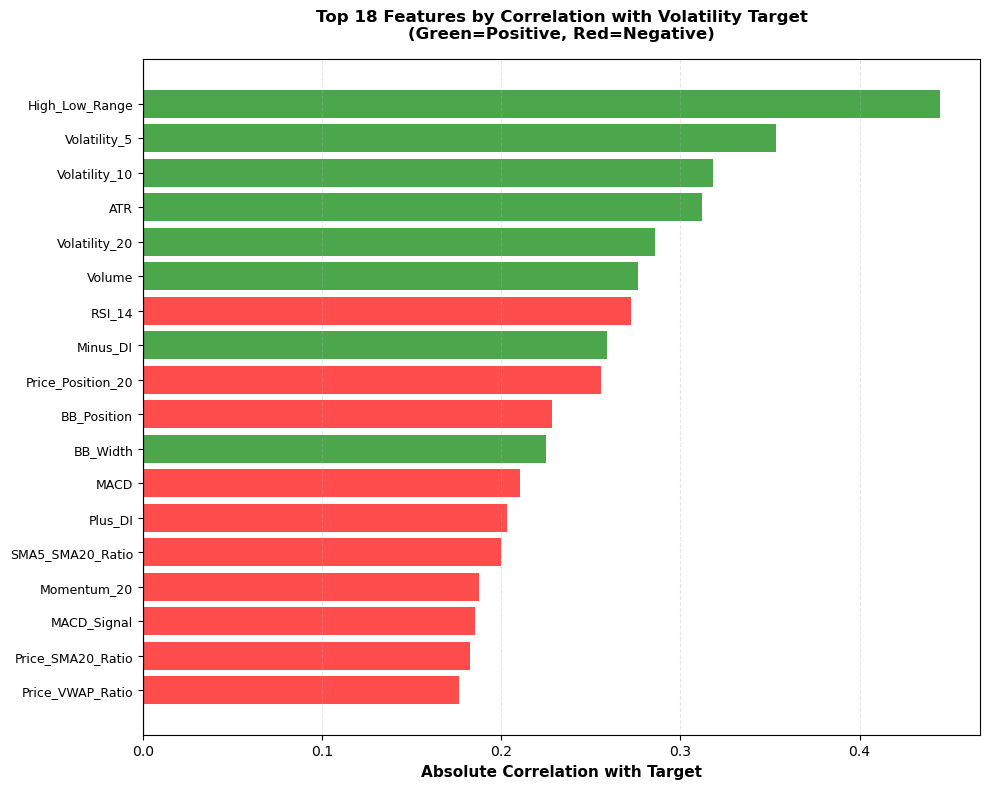

In [25]:
# Feature Engineering & Target Creation

# Create volatility target (high/low volatility next day)
next_volatility = df['Close'].pct_change(-1).shift(1).abs()
vol_threshold = next_volatility.median()
df['Target'] = (next_volatility > vol_threshold).astype(int)

# Price features
df['High_Low_Range'] = (df['High'] - df['Low']) / df['Close']
df['Open_Close_Range'] = (df['Close'] - df['Open']) / df['Open']

# Moving averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['Price_SMA5_Ratio'] = df['Close'] / df['SMA_5'] - 1
df['Price_SMA20_Ratio'] = df['Close'] / df['SMA_20'] - 1
df['SMA5_SMA20_Ratio'] = df['SMA_5'] / df['SMA_20'] - 1

# RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = calculate_rsi(df['Close'])

# MACD
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# Momentum
df['Momentum_5'] = df['Close'].pct_change(5)
df['Momentum_10'] = df['Close'].pct_change(10)
df['Momentum_20'] = df['Close'].pct_change(20)
df['ROC_5'] = (df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)
df['ROC_10'] = (df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)

# Bollinger Bands
bb_middle = df['Close'].rolling(20).mean()
bb_std = df['Close'].rolling(20).std()
df['BB_Width'] = (bb_std * 4) / bb_middle
df['BB_Position'] = (df['Close'] - (bb_middle - 2*bb_std)) / (4*bb_std).replace(0, np.nan)

# Volatility indicators
df['Volatility_5'] = df['Close'].pct_change().rolling(5).std()
df['Volatility_10'] = df['Close'].pct_change().rolling(10).std()
df['Volatility_20'] = df['Close'].pct_change().rolling(20).std()

# ATR
high_low = df['High'] - df['Low']
high_close = abs(df['High'] - df['Close'].shift(1))
low_close = abs(df['Low'] - df['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = true_range.rolling(14).mean() / df['Close']

# ADX
def calculate_adx(high, low, close, period=14):
    plus_dm = high.diff().clip(lower=0)
    minus_dm = (-low.diff()).clip(lower=0)
    tr = pd.concat([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))], axis=1).max(axis=1)
    atr = tr.rolling(period).mean().replace(0, np.nan)
    plus_di = 100 * (plus_dm.rolling(period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(period).mean() / atr)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di).replace(0, np.nan)
    return dx.rolling(period).mean(), plus_di, minus_di

df['ADX'], df['Plus_DI'], df['Minus_DI'] = calculate_adx(df['High'], df['Low'], df['Close'])

# Price position
high_5 = df['High'].rolling(5).max()
low_5 = df['Low'].rolling(5).min()
df['Price_Position_5'] = (df['Close'] - low_5) / (high_5 - low_5).replace(0, np.nan)
high_20 = df['High'].rolling(20).max()
low_20 = df['Low'].rolling(20).min()
df['Price_Position_20'] = (df['Close'] - low_20) / (high_20 - low_20).replace(0, np.nan)

# Volume indicators
df['Volume_Change'] = df['Volume'].pct_change()
df['Volume_SMA_20'] = df['Volume'].rolling(20).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df['OBV_Change'] = df['OBV'].pct_change()
volume_sum = df['Volume'].rolling(20).sum().replace(0, np.nan)
df['VWAP'] = (df['Close'] * df['Volume']).rolling(20).sum() / volume_sum
df['Price_VWAP_Ratio'] = (df['Close'] / df['VWAP']) - 1

# Statistical features
df['Skewness_10'] = df['Close'].pct_change().rolling(10).skew()
df['Kurtosis_10'] = df['Close'].pct_change().rolling(10).kurt()

# Trend strength
df['Trend_Strength_20'] = abs(df['Close'] - df['SMA_20']) / df['SMA_20']
df['Trend_Strength_50'] = abs(df['Close'] - df['SMA_50']) / df['SMA_50']

# Clean features
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Candidate features (excluding leaky features and target)
candidate_features = [
    'Close', 'High_Low_Range', 'Open_Close_Range',
    'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
    'Price_SMA5_Ratio', 'Price_SMA20_Ratio', 'SMA5_SMA20_Ratio',
    'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Histogram',
    'Momentum_5', 'Momentum_10', 'Momentum_20', 'ROC_5', 'ROC_10',
    'BB_Width', 'BB_Position',
    'Volatility_5', 'Volatility_10', 'Volatility_20', 'ATR',
    'ADX', 'Plus_DI', 'Minus_DI',
    'Price_Position_5', 'Price_Position_20',
    'Volume', 'Volume_Change', 'Volume_Ratio', 'OBV_Change', 'Price_VWAP_Ratio',
    'Skewness_10', 'Kurtosis_10',
    'Trend_Strength_20', 'Trend_Strength_50'
]

# Filter to only include features that exist in dataframe
candidate_features = [f for f in candidate_features if f in df.columns]

# Calculate correlations with target
correlations = df[candidate_features].corrwith(df['Target']).abs().sort_values(ascending=False)

# Select top N features
feature_columns = correlations.head(N_TOP_FEATURES).index.tolist()

# Create feature matrix and target
X = df[feature_columns].copy()
y = df['Target'].copy()

# Display feature selection results
print("="*60)
print(f"FEATURE SELECTION: Top {N_TOP_FEATURES} features by correlation")
print("="*60)
print(f"\nTotal candidate features: {len(candidate_features)}")
print(f"Selected features: {len(feature_columns)}")
print("\nSelected features (ranked by absolute correlation):")
for i, (feat, corr) in enumerate(correlations.head(N_TOP_FEATURES).items(), 1):
    sign = '+' if df[feat].corr(df['Target']) >= 0 else '-'
    print(f"  {i:2d}. {feat:25s} | Correlation: {sign}{corr:.4f}")
print("="*60)
print(f"\n✓ Created {len(feature_columns)} features")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Visualize feature correlations
fig, ax = plt.subplots(figsize=(10, 8))
top_correlations_abs = correlations.head(N_TOP_FEATURES).sort_values(ascending=True)
top_features_list = top_correlations_abs.index.tolist()
actual_correlations = df[top_features_list].corrwith(df['Target'])
colors = ['red' if actual_correlations[feat] < 0 else 'green' for feat in top_features_list]
ax.barh(range(len(top_correlations_abs)), top_correlations_abs.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_correlations_abs)))
ax.set_yticklabels(top_features_list, fontsize=9)
ax.set_xlabel('Absolute Correlation with Target', fontsize=11, fontweight='bold')
ax.set_title(f'Top {N_TOP_FEATURES} Features by Correlation with Volatility Target\n(Green=Positive, Red=Negative)', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


## Cell 4: Data Splitting & Sequence Creation

This cell splits the data into training, validation, and test sets based on date ranges. It applies MinMaxScaler to normalize the features (fit on training data, transform on validation and test). Then it creates sequences of length WINDOW_SIZE (30 days) for the LSTM model, where each sequence contains 30 consecutive days of features to predict the next day's volatility class.


In [26]:
# Data Splitting & Sequence Creation

# Split by date
train_data = X[X.index <= TRAIN_END].copy()
train_labels = y[y.index <= TRAIN_END].copy()
val_data = X[(X.index > TRAIN_END) & (X.index <= VAL_END)].copy()
val_labels = y[(y.index > TRAIN_END) & (y.index <= VAL_END)].copy()
test_data = X[(X.index > VAL_END) & (X.index < TEST_END)].copy()
test_labels = y[(y.index > VAL_END) & (y.index < TEST_END)].copy()

# Scale data
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(
    scaler.fit_transform(train_data),
    columns=train_data.columns,
    index=train_data.index
)
val_data_scaled = pd.DataFrame(
    scaler.transform(val_data),
    columns=val_data.columns,
    index=val_data.index
)
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    columns=test_data.columns,
    index=test_data.index
)

# Create sequences
def create_sequences(features, labels, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(features)):
        X_seq.append(features.iloc[i-window_size:i].values)
        y_seq.append(labels.iloc[i])
    return np.array(X_seq), np.array(y_seq)

X_train, y_train = create_sequences(train_data_scaled, train_labels, WINDOW_SIZE)
X_val, y_val = create_sequences(val_data_scaled, val_labels, WINDOW_SIZE)
X_test, y_test = create_sequences(test_data_scaled, test_labels, WINDOW_SIZE)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("✓ Data prepared")


Train: (1935, 30, 18), Val: (219, 30, 18), Test: (222, 30, 18)
✓ Data prepared


## Cell 5: Build & Train Model

This cell constructs a two-layer LSTM neural network with dropout regularization for binary classification. The model architecture includes:
- Two LSTM layers (50 and 100 units)
- Dropout layers to prevent overfitting
- Dense layers for final prediction

The model is compiled with binary cross-entropy loss and Adam optimizer. Class weights are computed to handle class imbalance. Training uses early stopping and model checkpointing to save the best model based on validation accuracy. The training history (accuracy and loss) is visualized after training completes.


Epoch 1/50
30/31 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.5938
Epoch 1: val_accuracy improved from -inf to 0.54338, saving model to models\sp500_volatility_best.h5
31/31 [==============================] - 5s 61ms/step - loss: 0.6655 - accuracy: 0.5938 - val_loss: 0.6854 - val_accuracy: 0.5434
Epoch 2/50
29/31 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.6282
Epoch 2: val_accuracy improved from 0.54338 to 0.57078, saving model to models\sp500_volatility_best.h5
31/31 [==============================] - 1s 28ms/step - loss: 0.6474 - accuracy: 0.6248 - val_loss: 0.6759 - val_accuracy: 0.5708
Epoch 3/50
30/31 [============================>.] - ETA: 0s - loss: 0.6352 - accuracy: 0.6531
Epoch 3: val_accuracy did not improve from 0.57078
31/31 [==============================] - 1s 25ms/step - loss: 0.6342 - accuracy: 0.6548 - val_loss: 0.6814 - val_accuracy: 0.5662
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.62

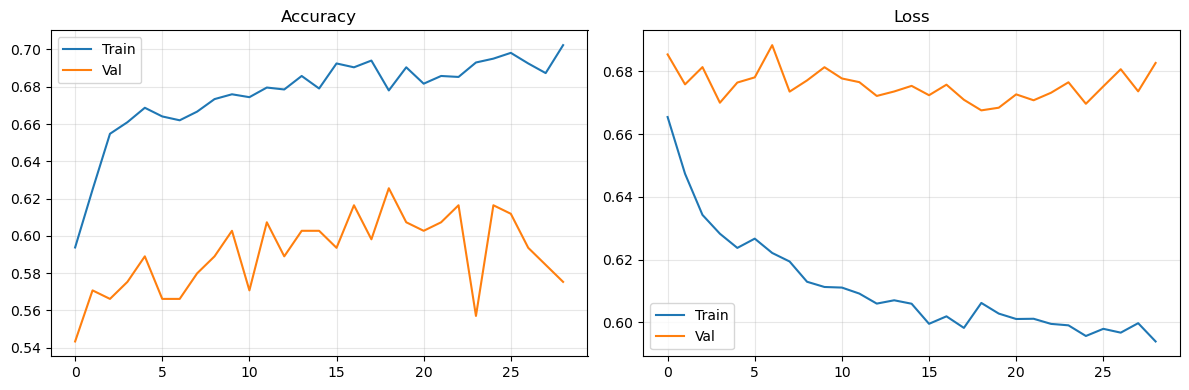

✓ Training complete. Best val accuracy: 0.6256


In [27]:
# Build & Train Model

# Build model
model = Sequential([
    LSTM(LSTM_UNITS_1, return_sequences=True, input_shape=(WINDOW_SIZE, len(feature_columns))),
    Dropout(DROPOUT_RATE),
    LSTM(LSTM_UNITS_2, return_sequences=False),
    Dropout(DROPOUT_RATE),
    Dense(DENSE_UNITS, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Callbacks
os.makedirs('models', exist_ok=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('models/sp500_volatility_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Training complete. Best val accuracy: {max(history.history['val_accuracy']):.4f}")


## Cell 6: Evaluation

This cell evaluates the trained model on the test set. It generates predictions and calculates comprehensive metrics including accuracy, precision, recall, F1-score, and ROC-AUC. It displays a classification report and visualizes the results with a confusion matrix heatmap and ROC curve to assess the model's performance in predicting high volatility days.


TEST SET EVALUATION
Accuracy:  0.5946
Precision: 0.6212
Recall:    0.3868
F1-Score:  0.4767
ROC-AUC:   0.6286

Classification Report:
              precision    recall  f1-score   support

     Low Vol       0.58      0.78      0.67       116
    High Vol       0.62      0.39      0.48       106

    accuracy                           0.59       222
   macro avg       0.60      0.59      0.57       222
weighted avg       0.60      0.59      0.58       222



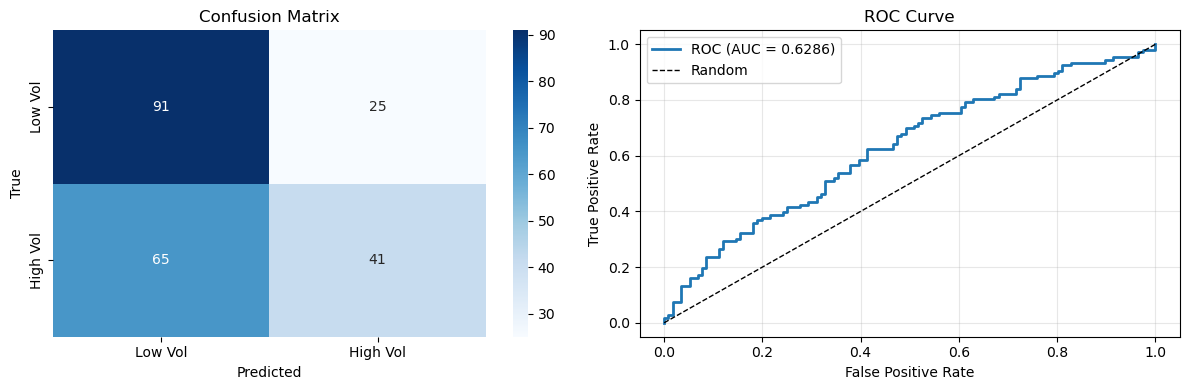

✓ Evaluation complete


In [28]:
# Evaluation

y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Vol', 'High Vol']))

# Confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Low Vol', 'High Vol'], yticklabels=['Low Vol', 'High Vol'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Evaluation complete")


## Cell 7: Save Model & Artifacts

This cell saves the trained model, the feature scaler, and feature metadata (feature column names and window size) to disk. These artifacts are necessary for loading and using the model for future predictions on new data.


In [7]:
# # Save Model & Artifacts

# model.save('models/sp500_volatility_model.h5')
# with open('models/sp500_volatility_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# with open('models/sp500_volatility_features.pkl', 'wb') as f:
#     pickle.dump({'feature_columns': feature_columns, 'window_size': WINDOW_SIZE}, f)

# print("✓ Model and artifacts saved")


## Cell 8: 10-Fold Cross Validation

This cell performs 10-fold cross-validation on the training data to assess model stability and generalization. Since this is time series data, it uses TimeSeriesSplit to maintain temporal order in the folds. For each fold, it trains a new LSTM model with the same architecture and hyperparameters, then evaluates it on the validation fold. The results from all folds are collected for statistical analysis.


In [11]:
# 10-Fold Cross Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight

# Combine train and validation data for cross-validation
X_cv = np.concatenate([X_train, X_val], axis=0)
y_cv = np.concatenate([y_train, y_val], axis=0)

# Use TimeSeriesSplit for temporal cross-validation
# If we can't get exactly 10 folds, we'll use the maximum possible
tscv = TimeSeriesSplit(n_splits=10)
n_splits = min(10, tscv.get_n_splits(X_cv))
if n_splits < 10:
    print(f"Note: Using {n_splits} folds instead of 10 due to data size")
    tscv = TimeSeriesSplit(n_splits=n_splits)

# Store results for each fold
cv_results = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'val_loss': []
}

print("="*60)
print(f"Starting {n_splits}-Fold Cross Validation")
print("="*60)

fold = 1
for train_idx, val_idx in tscv.split(X_cv):
    print(f"\nFold {fold}/{n_splits}...")
    
    # Split data for this fold
    X_train_fold = X_cv[train_idx]
    y_train_fold = y_cv[train_idx]
    X_val_fold = X_cv[val_idx]
    y_val_fold = y_cv[val_idx]
    
    # Compute class weights for this fold
    class_weights_fold = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weight_dict_fold = {i: weight for i, weight in enumerate(class_weights_fold)}
    
    # Build model for this fold
    model_cv = Sequential([
        LSTM(LSTM_UNITS_1, return_sequences=True, input_shape=(WINDOW_SIZE, len(feature_columns))),
        Dropout(DROPOUT_RATE),
        LSTM(LSTM_UNITS_2, return_sequences=False),
        Dropout(DROPOUT_RATE),
        Dense(DENSE_UNITS, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model_cv.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['accuracy']
    )
    
    # Train with early stopping
    early_stopping_cv = EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Train model
    history_cv = model_cv.fit(
        X_train_fold, y_train_fold,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_cv],
        class_weight=class_weight_dict_fold,
        verbose=0
    )
    
    # Evaluate on validation fold
    y_pred_proba_fold = model_cv.predict(X_val_fold, verbose=0)
    y_pred_fold = (y_pred_proba_fold > 0.5).astype(int).flatten()
    
    # Calculate metrics
    acc = accuracy_score(y_val_fold, y_pred_fold)
    prec = precision_score(y_val_fold, y_pred_fold, zero_division=0)
    rec = recall_score(y_val_fold, y_pred_fold, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred_fold, zero_division=0)
    roc = roc_auc_score(y_val_fold, y_pred_proba_fold)
    val_loss = min(history_cv.history['val_loss'])
    
    # Store results
    cv_results['fold'].append(fold)
    cv_results['accuracy'].append(acc)
    cv_results['precision'].append(prec)
    cv_results['recall'].append(rec)
    cv_results['f1'].append(f1)
    cv_results['roc_auc'].append(roc)
    cv_results['val_loss'].append(val_loss)
    
    print(f"  Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    
    # Clear model to free memory
    del model_cv
    tf.keras.backend.clear_session()
    
    fold += 1

print("\n" + "="*60)
print("Cross Validation Complete")
print("="*60)
print(f"✓ Completed {len(cv_results['fold'])} folds")


Starting 10-Fold Cross Validation

Fold 1/10...
  Accuracy: 0.6308, F1: 0.2941, ROC-AUC: 0.5512

Fold 2/10...
  Accuracy: 0.7692, F1: 0.0000, ROC-AUC: 0.4914

Fold 3/10...
  Accuracy: 0.7128, F1: 0.5882, ROC-AUC: 0.7133

Fold 4/10...
  Accuracy: 0.6923, F1: 0.6842, ROC-AUC: 0.7152

Fold 5/10...
  Accuracy: 0.6974, F1: 0.5874, ROC-AUC: 0.6789

Fold 6/10...
  Accuracy: 0.7538, F1: 0.8345, ROC-AUC: 0.7280

Fold 7/10...
  Accuracy: 0.5949, F1: 0.5907, ROC-AUC: 0.6304

Fold 8/10...
  Accuracy: 0.7538, F1: 0.7966, ROC-AUC: 0.7506

Fold 9/10...
  Accuracy: 0.7179, F1: 0.8358, ROC-AUC: 0.5903

Fold 10/10...
  Accuracy: 0.6051, F1: 0.4901, ROC-AUC: 0.6248

Cross Validation Complete
✓ Completed 10 folds
✓ Best fold: 2 (Accuracy: 0.7692)


## Cell 9: Cross-Validation Results

This cell displays comprehensive statistics from the cross-validation results, including mean, standard deviation, and confidence intervals for all metrics. It also visualizes the distribution of metrics across folds using box plots to show the variability in model performance.


CROSS-VALIDATION RESULTS SUMMARY

Accuracy:
  Mean ± Std:    0.6928 ± 0.0596
  Median:        0.7051
  Range:         [0.5949, 0.7692]
  95% CI:        [0.6479, 0.7377]

Precision:
  Mean ± Std:    0.6174 ± 0.2187
  Median:        0.6811
  Range:         [0.0000, 0.8121]
  95% CI:        [0.4524, 0.7823]

Recall:
  Mean ± Std:    0.5560 ± 0.2916
  Median:        0.5447
  Range:         [0.0000, 1.0000]
  95% CI:        [0.3361, 0.7759]

F1-Score:
  Mean ± Std:    0.5702 ± 0.2477
  Median:        0.5895
  Range:         [0.0000, 0.8358]
  95% CI:        [0.3834, 0.7569]

ROC-AUC:
  Mean ± Std:    0.6474 ± 0.0805
  Median:        0.6547
  Range:         [0.4914, 0.7506]
  95% CI:        [0.5867, 0.7081]

Validation Loss:
  Mean ± Std:    0.6105 ± 0.0435
  Median:        0.6088
  Range:         [0.5260, 0.6692]
  95% CI:        [0.5776, 0.6433]

PER-FOLD RESULTS
Fold   Accuracy   Precision  Recall     F1-Score   ROC-AUC   
------------------------------------------------------------------

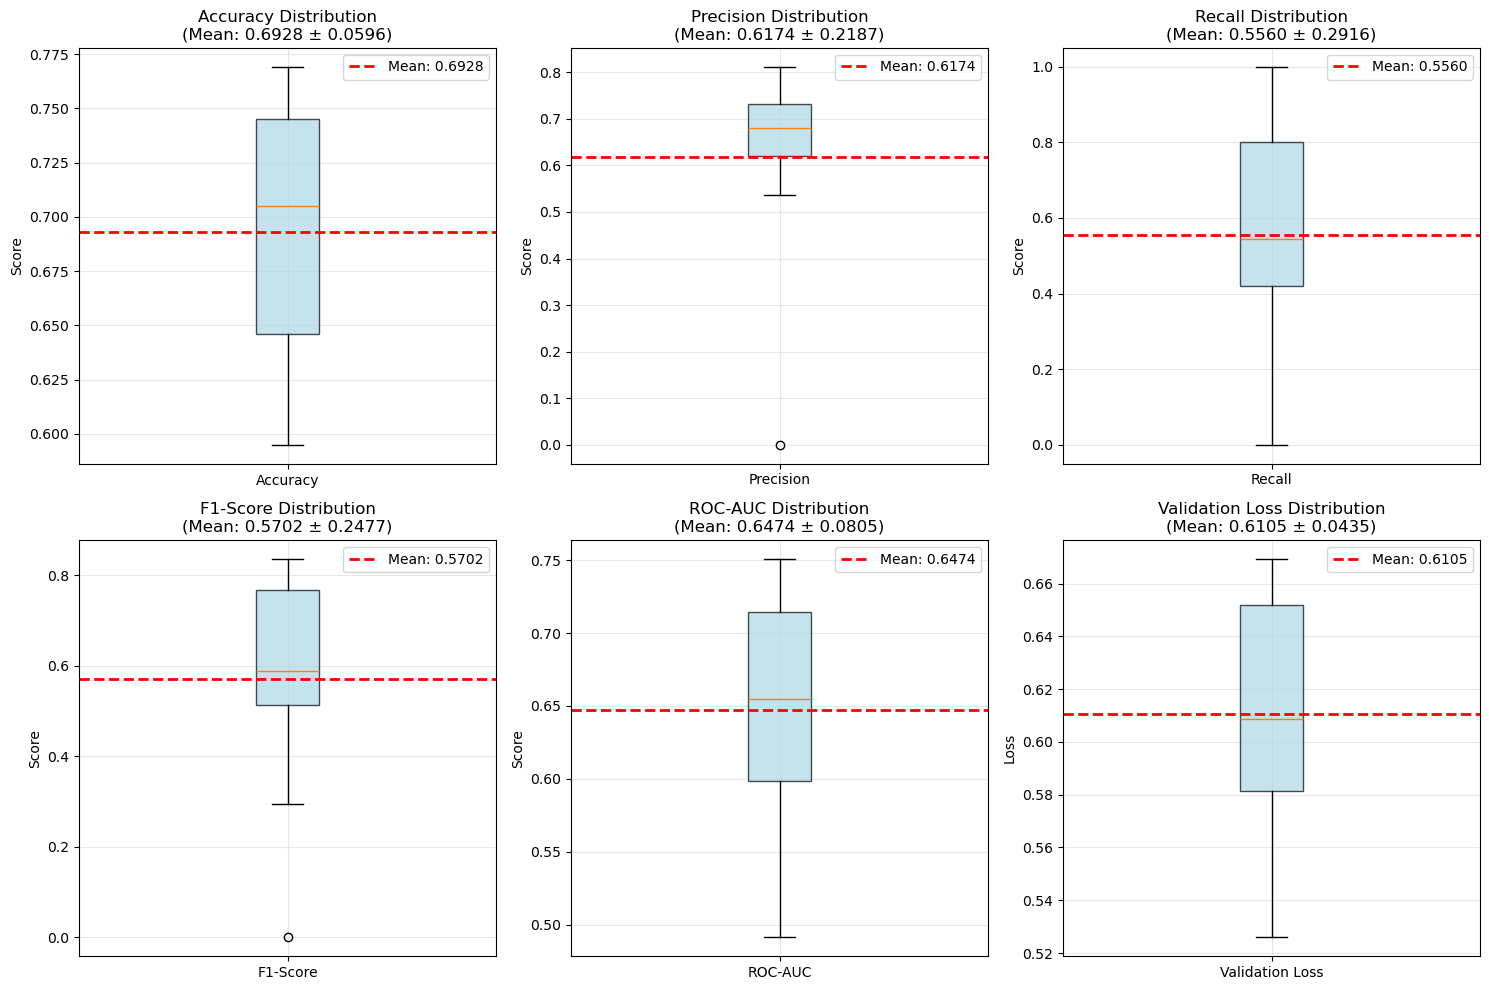

✓ Cross-validation results displayed


In [12]:
# Print Cross-Validation Results
import statistics

print("="*70)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)

# Calculate statistics for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'val_loss']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Validation Loss']

results_summary = {}
for metric, name in zip(metrics, metric_names):
    values = cv_results[metric]
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    median_val = np.median(values)
    
    # 95% confidence interval
    from scipy import stats
    if len(values) > 1:
        ci = stats.t.interval(0.95, len(values)-1, loc=mean_val, scale=stats.sem(values))
        ci_lower, ci_upper = ci
    else:
        ci_lower, ci_upper = mean_val, mean_val
    
    results_summary[metric] = {
        'mean': mean_val,
        'std': std_val,
        'min': min_val,
        'max': max_val,
        'median': median_val,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    
    print(f"\n{name}:")
    print(f"  Mean ± Std:    {mean_val:.4f} ± {std_val:.4f}")
    print(f"  Median:        {median_val:.4f}")
    print(f"  Range:         [{min_val:.4f}, {max_val:.4f}]")
    print(f"  95% CI:        [{ci_lower:.4f}, {ci_upper:.4f}]")

print("\n" + "="*70)
print("PER-FOLD RESULTS")
print("="*70)
print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
print("-"*70)
for i in range(len(cv_results['fold'])):
    print(f"{cv_results['fold'][i]:<6} "
          f"{cv_results['accuracy'][i]:<10.4f} "
          f"{cv_results['precision'][i]:<10.4f} "
          f"{cv_results['recall'][i]:<10.4f} "
          f"{cv_results['f1'][i]:<10.4f} "
          f"{cv_results['roc_auc'][i]:<10.4f}")

print("\n" + "="*70)
print("OVERALL STATISTICS")
print("="*70)
print(f"Number of folds: {len(cv_results['fold'])}")
print(f"Mean Accuracy:   {results_summary['accuracy']['mean']:.4f} ± {results_summary['accuracy']['std']:.4f}")
print(f"Mean F1-Score:   {results_summary['f1']['mean']:.4f} ± {results_summary['f1']['std']:.4f}")
print(f"Mean ROC-AUC:    {results_summary['roc_auc']['mean']:.4f} ± {results_summary['roc_auc']['std']:.4f}")
print("="*70)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    values = cv_results[metric]
    
    # Box plot
    bp = ax.boxplot(values, patch_artist=True, labels=[name])
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    
    # Add mean line
    mean_val = np.mean(values)
    ax.axhline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
    
    ax.set_ylabel('Score' if metric != 'val_loss' else 'Loss')
    ax.set_title(f'{name} Distribution\n(Mean: {mean_val:.4f} ± {np.std(values):.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("✓ Cross-validation results displayed")
